fuente: https://www.youtube.com/watch?v=W8AeOXa_FqU
Carlos Santana

In [1]:
#@title librerias
import  numpy as np
import  scipy as sc
import  matplotlib.pyplot as plt
from    sklearn.datasets import make_circles
import  math

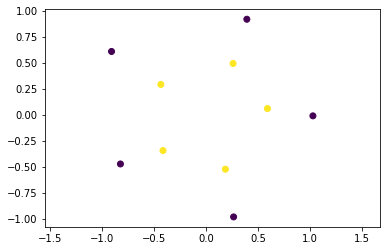

array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1]])

In [2]:
#@title datos de para entrenamiento
n = 10      # cantidad samples
p = 2       # entradas
X_coord, Y_class = make_circles(n_samples=n, factor=0.5, noise=0.05)

plt.scatter(X_coord[:,0], X_coord[:,1], c=Y_class)
plt.axis("equal")
plt.show()

Y_class = Y_class[:, np.newaxis]      # agrega una dimension para pasar por multiplicaciones matriciales
Y_class

In [161]:
#@title clase de una capa neuronal
import copy

class capa_neuronal():
  def __init__(self, n_entradas, n_neuronas, act_f, rango_W=2, rango_b=0.00001):
    self.n_entrada = n_entradas   # neuronas de entrada     cantidad
    self.n_salidas = n_neuronas   # neuronas de salida      cantidad
    #self.act_f = act_f            # funcion activacion puntero memoria
    self.func_activacion, self.deriv_activacion = act_f                 # funcion de activacion y su derivada
    #arr = np.full((M, N), 0.5)
    #arr_pos = np.full((n_entradas, math.ceil(n_neuronas/2)), 0.5)
    #arr_neg = np.full((n_entradas, n_neuronas//2), -0.5)
    #arr = np.hstack((arr_pos, arr_neg))
    #self.b = np.full((1, n_neuronas), 0.33) # * 2 -1             # una por cada neurona   ini aleatoria
    #self.W = np.hstack((arr_pos, arr_neg)) # * 2 -1    # una por cada entrada/neurona (conexion)   ini aleatoria

    #self.b = np.full((1, n_neuronas), 1) # * 2 -1             # una por cada neurona   ini aleatoria
    #self.W = np.full((n_entradas, n_neuronas), 1) # * 2 -1    # una por cada entrada/neurona (conexion)   ini aleatoria
    self.b = np.random.rand(1, n_neuronas) * rango_b - (rango_b//2)            # una por cada neurona   ini aleatoria
    self.W = np.random.rand(n_entradas, n_neuronas) * rango_W - (rango_W//2)    # una por cada entrada/neurona (conexion)   ini aleatoria

    #self.b = np.random.rand(1, n_neuronas) * 2 -1             # una por cada neurona   ini aleatoria
    #self.W = np.random.rand(n_entradas, n_neuronas) * 2 -1    # una por cada entrada/neurona (conexion)   ini aleatoria
    self.W_ = []                  # peso anterior por cada Neurona/Entrada          W_ = W    respaldo
    self.b_ = []                  # peso anterior por cada Neurona/Entrada          b_ = b    respaldo

    self.W_i = []                  # peso anterior por cada Neurona/Entrada          W_ = W    respaldo
    self.b_i = []                  # peso anterior por cada Neurona/Entrada          b_ = b    respaldo

    self.X = []                   # in (valor entrada) por cada entrada
    self.neurona = []             # neurona por cada Neurona/Muestra                X * W + b
    self.activa = []              # activacion por cada Neurona/Muestra             eqiv  Y"
    self.dactiva = []             # derivada activacion por cada Neurona/Muestra
    self.loss = []                # loss por cada Muestra                           (Y" - Y) **2
    self.dloss = []               # derivada loss por cada Neurona/Muestra          ULTIMA CAPA: l2_cost[derv](a, Y)  o/o  CAPAS ANTERIORES: deltas[0] @  w_.T
    self.dloss_back = []          # derivada loss capa siguiente en backprop por cada Neurona/Muestra                   (Y" - Y) **2
    self.delta = []               # delta por cada Neurona/Muestra                  dloss * dactiv
    self.grad_W = []              # gradiente descendente por cada Neurona/Entrada  dactiv.T @ delta * lr       = out[l][actv].T @ deltas[0] * lr 
    self.grad_b = []              # gradiente descendente por cada Neurona          mdelta * lr                 = np.mean(deltas[0], axis=0, keepdims=True) * lr 

  #snapshot
  def shot(self):
    self.W_i = self.W.copy()
    self.b_i = self.b.copy()

  def rollback(self):
    self.W = self.W_i.copy()
    self.b = self.b_i.copy()

  def backup(self):
    return copy.deepcopy(self)


In [ ]:
math.ceil(1/2)


1

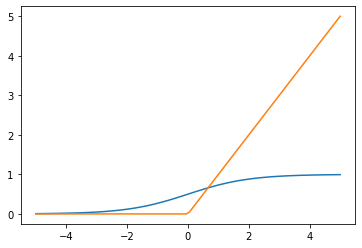

In [4]:
#@title funciones de activacion

#sigm = lambda x: 1/(1 + np.e ** (-x))
func = 0  # pos 0 en arr
derv = 1  # pos 1 en arr

sigm = (lambda x: 1/(1 + np.e ** (-x)), 
        lambda x: x * (1-x))

relu = (lambda x: np.maximum(0, x), 
        lambda x: 0 if x <= 0 else 1)

#sigm[0](1)

_x = np.linspace(-5, 5, 100)
plt.plot(_x, sigm[0](_x))
plt.plot(_x, relu[0](_x))

In [5]:
#@title funcion de costo
l2_cost = (lambda Yp, Yr: np.mean((Yp - Yr) ** 2),
          lambda Yp, Yr: (Yp - Yr))

# func_costo, deriv_costo = l2_cost


In [6]:
#@title funcion para crear una red neuronal

#ideal poder utilizar distintas func activacion por capa
#l0 = capa_neuronal(p, 4, sigm)
#l1 = capa_neuronal(4, 1, sigm)

def crea_nn(topologia, act_f):
  nn = [] # red inicial 
  for l, layer in enumerate(topologia[:-1]):
    in_ = topologia[l]
    out_ = topologia[l+1]
    nn.append(capa_neuronal(in_, out_, act_f))
  return nn


In [ ]:
#@title random reploducibilidad
import random
random.seed(888)


In [7]:
#@title creando red
topologia = [p, 4, 8, 1]
red = crea_nn(topologia, sigm)

In [8]:
#@title funcion de entrenamiento mas clara
def train(red, X, Y, l2_cost, lr=0.5, train=True):
  #X      = X_coord
  #Y      = Y_class
  #lr     = 0.5
  #train  = True

  #asigna la funcion de costo y su derivada
  func_costo, deriv_costo = l2_cost

  #primera capa de Entrada
  red[0].X              = X.copy()                           # X valor entrada primera capa

  #forward
  for l, layer in enumerate(red):                               # por cada capa de la primera hasta la ultima
    if(l>0):layer.X     = red[l-1].activa.copy()             # la salida de la anterior capa es la entrada de esta
    layer.neurona       = layer.X @ layer.W + layer.b           # neurona
    layer.activa        = layer.func_activacion(layer.neurona)  # activacion

  #calc loss en ultima capa
  layer.loss            = func_costo(layer.activa, Y)     # loss solo en ultima capa

  if(train):

    #backward
    for l in reversed(range(0, len(red))):
      layer             = red[l]                          # capa de la red
      layer.W_          = layer.W.copy()                  # respaldo W solo para historial
      layer.b_          = layer.b.copy()                  # respaldo b solo para historial

      #calc responsabilidad
      if( l == len(red)-1):                               # ultima capa
        #anticipa next layer loss
        layer.dloss     = deriv_costo(layer.activa, Y)
      else :                                              # previas capas
        #copia loss arrastre precalculado
        layer.dloss     = red[l+1].dloss_back             # loss actual es Delta @ W_ original anterior

      #calc derivada activacion
      layer.dactiva      = layer.deriv_activacion(layer.activa) #layer.neurona)

      #actualiza delta
      layer.delta       = layer.dloss * layer.dactiva     # delta_ant @ W_ant.T * dactiv(activ)

      #anticipa next layer loss
      layer.dloss_back  = layer.delta @ layer.W.T         # loss actual es Delta @ W_ original

      #gradiente 
      layer.grad_b      = np.mean(layer.delta, axis=0, keepdims=True)
      layer.grad_W      = layer.X.T @ layer.delta


      #actualiza los pesos    con gradiente descendente
      #lr_b = 1/(layer.n_salidas)
      layer.b           = layer.b - layer.grad_b * lr

      #lr = 1/(layer.n_entrada * layer.n_salidas)
      layer.W           = layer.W - layer.grad_W * lr

  #red[-1].activ                                          # ultima capa, activacion  
  return red[-1].activa                                    # ultima capa, activacion 

In [ ]:
#@title
#funcion de entrenamiento
def train(red, X, Y, l2_cost, lr=0.5, train=True):
  #X = X_coord
  #Y = Y_class
  #lr = 0.5
  #train = True

  #primera capa de Entrada
  red[0].X           = X.copy()                                   # X valor entrada primera capa

  #forward
  for l, layer in enumerate(red):                       # por cada capa de la primera hasta la ultima
    if(l>0): layer.X = red[l-1].activ.copy()            # la salida de la anterior capa es la entrada de esta
    #print(f"forward l:{l} X:{layer.X.shape} x W:{layer.W.shape} + b:{layer.b.shape}")
    layer.neurona    = layer.X @ layer.W + layer.b         # neurona
    layer.activ      = layer.act_f[func](layer.neurona)      # activacion

  #calc loss en ultima capa
  layer.loss      = l2_cost[func](layer.activ, Y)            # loss solo en ultima capa

  if(train):


    #gradiente desendente
    #layer.grad_b   = np.mean(layer.delta, axis=0, keepdims=True)
    #layer.grad_W   = layer.activ.T @ layer.delta
    #layer.grad_W   = layer.X.T @ layer.delta

    #actualiza los pesos
    #layer.b        = layer.b - layer.grad_b * lr
    #layer.W        = layer.W - layer.grad_W * lr


    #backward
    for l in reversed(range(0, len(red))):
      layer         = red[l]                  # capa de la red
      layer.W_      = layer.W.copy()          # respaldo W

      #calc derivada activacion
      layer.dactiv  = layer.act_f[derv](layer.activ)
      #print(f"dact l:{l} N:{layer.neurona.shape}  DACT{layer.dactiv.shape}  N:{layer.neurona}")

      #calc responsabilidad
      if( l == len(red)-1):                   # ultima capa
        #anticipa next layer loss
        #layer.dactiv    = layer.act_f[derv](layer.activ)
        layer.dloss     = l2_cost[derv](layer.activ, Y)
        #layer.delta     = layer.dloss * layer.dactiv
        #layer.W_        = layer.W.copy()          # respaldo W
        #layer.loss_back = layer.delta @ layer.W.T         # loss actual es Delta @ W_ original anterior
        None
        #print(f"last l:{l}")
        #layer.dloss = l2_cost[derv](layer.activ, Y)      l2_cost[derv](layer.activ, Y)
        #layer.delta = layer.loss * layer.dactiv
        #print(f"backward l:{l} X:{layer.X.shape} x Y:{layer.b.shape} + D:{len(layer.delta)} ")
        #print(f"DATOS l:{l} L:{l2_cost[derv](layer.activ, Y)} x ACT_D:{layer.dactiv} + D:{layer.delta} ")
      else :                                    # previas capas
        ##W_      = red[l+1].W_             # del respaldo W anterior
        ##delta   = red[l+1].delta          # delta previo
        ##layer.loss = delta @ W_.T         # loss actual es Delta @ W_ original anterior

        #copia loss arrastre precalculado
        layer.dloss  = red[l+1].dloss_back         # loss actual es Delta @ W_ original anterior
        #print(f"otras l:{l}")
        #print(f"delta l:{l} D:{red[l+1].delta}")
        #print(f"delta l:{l} DDDDD:{delta}")
        #print(f"DATOS l:{l} W:{W_.T} x ACT_D:{layer.dactiv} + D:{delta} ")
        #print(f"backwad l:{l} X:{layer.X.shape} x Y:{layer.b.shape} + D:{len(layer.delta)} Dx:{layer.delta.shape}")
        #layer.dloss = delta @ layer.W_.T 
        #layer.delta = delta @ layer.W_.T * layer.dactiv

      #actualiza delta
      layer.delta   = layer.dloss * layer.dactiv
      #layer.delta  = layer.loss * layer.dactiv
      #layer.delta  = layer.dloss * layer.dactiv
      #print(f"layer delta l:{l} DLOSS:{layer.dloss.shape} x DACT:{layer.dactiv.shape} + D:{len(layer.delta)} Dx:{layer.delta.shape}")
      #print(f"layer delta l:{l} DLOSS:{layer.dloss} x DACT:{layer.dactiv} + D:{len(layer.delta)} Dx:{layer.delta}")

      #anticipa next layer loss
      layer.dloss_back = layer.delta @ layer.W.T         # loss actual es Delta @ W_ original anterior

      #gradiente desendente
      layer.grad_b  = np.mean(layer.delta, axis=0, keepdims=True)
      #layer.grad_W = layer.activ.T @ layer.delta
      layer.grad_W  = layer.X.T @ layer.delta

      #actualiza los pesos
      layer.b       = layer.b - layer.grad_b * lr
      layer.W       = layer.W - layer.grad_W * lr

  #red[-1].activ                        # ultima capa, activacion  
  return red[-1].activ                        # ultima capa, activacion  


In [ ]:
#@title
for l, layer in enumerate(red):
  print(f"Layer:{l} -> {vars(layer)} \n")
  None
#vars(red[0])

In [ ]:
#@title  Imprimir las propiedades de obj de forma organizada
for l, layer in enumerate(red):
  print(f"\nLayer: {l}")
  for key, value in vars(layer).items():
    print(f"{key}: {value}")


Layer: 0
n_entrada: 2
n_salidas: 4
func_activacion: <function <lambda> at 0x7f91918bf160>
deriv_activacion: <function <lambda> at 0x7f91913ad790>
b: [[ 0.5594599  -0.42229982 -0.17436747 -0.74081021]]
W: [[ 0.56028011  0.92007317  0.81272205 -0.00757879]
 [-0.34342012 -0.01406495 -0.39352347  0.57730892]]
W_: [[ 0.56132769  0.92016929  0.81287633 -0.00784779]
 [-0.34255417 -0.01378073 -0.39350431  0.57720193]]
X: [[-0.48871225 -0.17299248]
 [ 0.09575208 -0.388011  ]
 [ 0.51673007  0.01187517]
 [ 0.19163239  0.88559552]
 [-0.8060531  -0.56556721]
 [-0.81880723  0.55190512]
 [-0.29389596  0.26188468]
 [ 0.10444856  0.47017052]
 [ 0.34110359 -0.93188005]
 [ 1.03496643 -0.02271834]]
neurona: [[ 0.34718277 -0.86889141 -0.50331807 -0.83769421]
 [ 0.74891428 -0.32812217  0.05638986 -0.96639007]
 [ 0.84823821  0.05373812  0.24123598 -0.73887875]
 [ 0.36645532 -0.25744729 -0.36684095 -0.23201437]
 [ 0.30352868 -1.15548874 -0.60679708 -1.06179868]
 [-0.08642537 -1.1826243  -1.05689479 -0.416691

In [ ]:
#@title
layer.W.shape, layer.grad_W.shape

((4, 8), (8, 8))

In [ ]:
#@title
layer.activ.T.shape, layer.delta.shape

((8, 10), (10, 8))

In [ ]:
#@title
layer.activ.T @ layer.delta

array([[ 0.05229722, -0.05792131, -0.02364503, -0.01670879,  0.05328396,
         0.02234197, -0.04943139,  0.04967762],
       [ 0.04769252, -0.05289323, -0.02157925, -0.015254  ,  0.0488222 ,
         0.02039752, -0.04509285,  0.04542674],
       [ 0.07208785, -0.07987288, -0.03257746, -0.02299602,  0.07351057,
         0.03079684, -0.06814321,  0.06838859],
       [ 0.02434608, -0.02698204, -0.01104183, -0.00784034,  0.02491848,
         0.01042023, -0.02301614,  0.02334956],
       [ 0.07547871, -0.08358167, -0.03410978, -0.02408724,  0.07683365,
         0.032235  , -0.07133961,  0.07159108],
       [ 0.04404607, -0.04882902, -0.01994642, -0.01412408,  0.04506459,
         0.01884131, -0.04164186,  0.04205568],
       [ 0.05445094, -0.06038003, -0.02463846, -0.01741962,  0.05571879,
         0.02328669, -0.05148135,  0.05186929],
       [ 0.08049324, -0.08917272, -0.03635646, -0.02564269,  0.08200853,
         0.03437604, -0.0760857 ,  0.07623466]])

In [ ]:
#@title
delta @  layer.W_.T

In [ ]:
#@title
 layer.W_.T

array([[-0.6611457 ,  0.62973521,  0.39368762, -0.50317098],
       [ 0.1459031 , -0.518754  ,  0.04397627, -0.52233526],
       [ 0.51669848,  0.84256351,  0.9832069 ,  0.77593359],
       [-0.97418716,  0.46128924, -0.35193395, -0.34988308],
       [-0.00491423,  0.50726172,  0.64407747, -0.82245804],
       [-0.41895597,  0.77629002, -0.92309638,  0.97469166],
       [ 0.78942643,  0.03530997,  0.96242662, -0.38597567],
       [ 0.49085145,  0.00472411,  0.26400078,  0.15931611]])

In [ ]:
#@title
layer.W_ * layer.dactiv.T

In [ ]:
#@title
red[2].X

In [ ]:
#@title
red[2].dloss, red[2].dactiv

In [ ]:
#@title
l, red[2].delta

In [ ]:
#@title
red[2].dloss , red[2].dactiv

In [ ]:
#@title
layer.W_.shape, delta.shape, layer.dloss.shape, layer.activ.shape, layer.neurona.shape

((8, 1), (10, 1), (10, 1), (10, 1), (10, 1))

In [ ]:
#@title
red[0]

In [ ]:
#@title imprimir formas de capas
for l, layer in enumerate(red):
  print(f"capa: {l}, X:{layer.X.shape}, W:{layer.W.shape}, b:{layer.b.shape}, N:{layer.neurona.shape}, A:{layer.activa.shape}, D:{layer.delta.shape}, GW:{layer.grad_W.shape}, Gb:{layer.grad_b.shape}, DlB:{layer.dloss_back.shape}")
  #for param in enumerate(layer):
  #   print(param[0])


capa: 0, X:(10, 2), W:(2, 4), b:(1, 4), N:(10, 4), A:(10, 4), D:(10, 4), GW:(2, 4), Gb:(1, 4), DlB:(10, 2)
capa: 1, X:(10, 4), W:(4, 8), b:(1, 8), N:(10, 8), A:(10, 8), D:(10, 8), GW:(4, 8), Gb:(1, 8), DlB:(10, 4)
capa: 2, X:(10, 8), W:(8, 0), b:(1, 0), N:(10, 0), A:(10, 0), D:(10, 0), GW:(8, 0), Gb:(1, 0), DlB:(10, 8)


In [ ]:
len(red)

3

In [ ]:
#@title
for l in reversed(range(0, len(red))):
 print(l)

2
1
0


In [ ]:
#@title
red[1].delta, l, len(red)-1


([], 1, 2)

In [ ]:
#@title funcion de entrenamiento orig
def train(red, X, Y, l2_cost, lr=0.5, train=True):
  #X = X_coord
  #Y = Y_class
  #lr = 0.5
  #train = True

  #out = [(z0, a0), (z1, a1)]   Neurona y Activacion
  neur = 0  # pos 0 en arr
  actv = 1  # pos 1 en arr
  out = [(None, X)] # X valor entrada primera capa

  #forward
  for l, layer in enumerate(red): #[:-1]):    # por cada capa de la primera hasta la penultima
    #print(l, layer)
    x_ = out[l][actv] # nueva entrada para esta capa
    #print(f"forward l:{l} X:{x_.shape} x W:{layer.W.shape} + b:{layer.b.shape}")
    z = x_ @ red[l].W + red[l].b  # neurona
    a = red[l].act_f[func](z)     # activacion
    out.append((z, a))            # salida de esta y entrada proxima capa
  #print(out)
  #print(l2_cost[func](out[-1][actv], Y))

  #print("AAA", out)
  #print("BBB", out[-1])
  #print("CCC", out[-1][actv])

  if(train):
    #backward
    deltas = []   # insertara en la prim posicion [0]
    #for l in reversed(range(0, len(red))):
    for l in reversed(range(0, len(red))):
      z = out[l+1][neur]    # neurona ultima capa
      a = out[l+1][actv]    # activacion ultima capa

      if( l == len(red)-1): # ultima capa
        #print(f"LAST:{l}")
        deltas.insert(0, l2_cost[derv](a, Y) * red[l].act_f[derv](a) )
        #print(f"DELTAS: {deltas[0]} L:{l2_cost[derv](a, Y)} ACTderv:{red[l].act_f[derv](a)}")
      else :                # previas capas
        #print(f"OTROS:{l}")
        deltas.insert(0, deltas[0] @  w_.T  *  red[l].act_f[derv](a) )
        #print(f"DELTAS: {deltas[0]} W:{w_.T} ACTderv:{red[l].act_f[derv](a)}")
      #print(f"backward l:{l} X:{a.shape} x Y:{Y.shape} + D:{len(deltas)} Dx:{deltas[0].shape}")

      w_ = red[l].W.copy()
      #gradiente desc
      red[l].b = red[l].b - np.mean(deltas[0], axis=0, keepdims=True) * lr 
      red[l].W = red[l].W - out[l][actv].T @ deltas[0] * lr 

  #out[-1][actv]   # ultima capa, activacion  
  return out[-1][actv]   # ultima capa, activacion  


In [ ]:
#@title
deltas[2].shape

(10, 1)

In [ ]:
#@title
X, out[0]

(array([[ 0.0796081 , -0.47792308],
        [ 0.94580899, -0.03637675],
        [ 0.33323536, -0.8837254 ],
        [-0.45218419, -0.26324709],
        [ 0.46475657, -0.10510195],
        [ 0.1044434 ,  0.42035808],
        [ 0.18521957,  0.92004546],
        [-0.75481632, -0.574926  ],
        [-0.39773426,  0.31675171],
        [-0.77669546,  0.59383067]]), (None, array([[ 0.0796081 , -0.47792308],
         [ 0.94580899, -0.03637675],
         [ 0.33323536, -0.8837254 ],
         [-0.45218419, -0.26324709],
         [ 0.46475657, -0.10510195],
         [ 0.1044434 ,  0.42035808],
         [ 0.18521957,  0.92004546],
         [-0.75481632, -0.574926  ],
         [-0.39773426,  0.31675171],
         [-0.77669546,  0.59383067]])))

In [ ]:
#@title entrenamiento base
train(red, X_coord, Y_class, l2_cost, 0.5)

array([[0.92887532],
       [0.92884748],
       [0.9288629 ],
       [0.92892994],
       [0.92898135],
       [0.92884634],
       [0.92884069],
       [0.9288669 ],
       [0.92886838],
       [0.92891992]])

In [ ]:
#@title
for l in reversed(range(0, len(red))):
  print (l )

2
1
0


In [ ]:
#@title
for l  in enumerate(reversed(range(0, len(red)))):
  print (l )

(0, 2)
(1, 1)
(2, 0)


In [ ]:
#@title
len(red), range(0, len(red)), reversed(range(0, len(red)))

(3, range(0, 3), <range_iterator at 0x7fd9fdb957b0>)

In [ ]:
#@title
X_coord[0]

array([-0.3268381 ,  0.24620944])

In [ ]:
#@title
red

In [ ]:
#@title
red[:-1]

In [ ]:
#@title
for l, layer in enumerate(red[:-1]):    # de la primera hasta la penultima
    print(l, layer)

0 <__main__.capa_neuronal object at 0x7fd9ff5c3670>
1 <__main__.capa_neuronal object at 0x7fd9ff5edc10>


In [ ]:
#@title
np.random.rand(2, 5) 

array([[0.59526058, 0.57757229, 0.08363081, 0.60117299, 0.03849489],
       [0.81383712, 0.54299208, 0.44524148, 0.79295923, 0.36377786]])

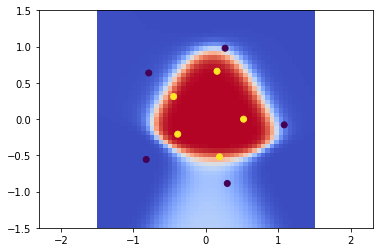

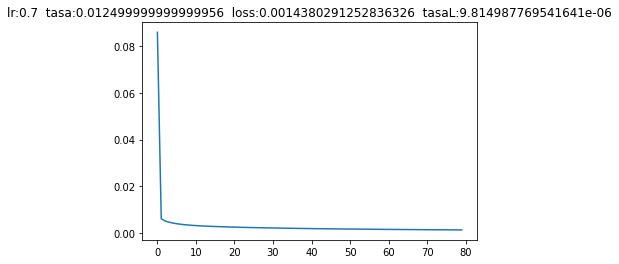

In [ ]:
#@title proceso de entrenamiento y test
import time
from IPython.display import clear_output

random.seed(888)

##topologia = [p, 3, 1]
#red = crea_nn(topologia, sigm)

##WL1 = np.array([[ 8.84243203,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])
#WL1 = np.array([[ 1,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])

##bL1 = np.array([[ 3.7654632 , -3.25091011, -2.91781571]])
#bL1 = np.array([[ -2 , -3.25091011, -2.91781571]])

##WL2 = np.array([[ 14.3519784 ],  [-18.93268329],  [-17.98428509]])
#WL2 = np.array([[ 3.3519784 ],  [-18.93268329],  [-17.98428509]])

##bL2 = np.array([[-2.53003652]])
##bL2 = np.array([[0.53003652]])

##red[0].W, red[0].b = WL1, bL1
##red[1].W, red[1].b = WL2, bL2

red[0].shot()
red[1].shot()

loss = []
LR = 1
lr = 0.7
tasa_var_loss  = 0
iteraciones = 2000

for i in range(iteraciones):
  #lr = LR * (1-(i/iteraciones))
  Py = train(red, X_coord, Y_class, l2_cost, lr)     # entrenamiento

  if i%25 ==0:
    loss.append(l2_cost[0](Py, Y_class))      # LOSS del entrenamiento

    if(len(loss) > 4):
      None
      #tasa_var_loss = loss[-1] / loss[-3] #loss[-3] - loss[-1] 
      #lr = lr / (tasa_var_loss)
      #if(tasa_var_loss > 0.001 ): lr *= tasa_var_loss #1.001
      #else:  lr *= 0.999

    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)
    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train(red, np.array([[x0, x1]]), Y_class, l2_cost, train=False)[0,0]   # verificacion

    plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")           # imprime la malla de resultados de la verificacion
    plt.axis("equal")

    #plt.scatter(X_coord[:,0], X_coord[:,1], c=Y_class)
    plt.scatter(X_coord[:,0], X_coord[:,1], c=Y_class)      # imprime los puntos

    clear_output(wait=True)
    plt.show()
    #TasaL = loss[-2]-loss[-1] if i>50: 0
    plt.title(f'lr:{lr}  tasa_i:{(1-(i/iteraciones))}  loss:{loss[-1]}  tasaL:{loss[-2]-loss[-1] if i>50 else 0}')
    plt.plot(range(len(loss)), loss)                        # imprime el loss
    plt.show()
    time.sleep(0.5)

In [ ]:
red[0].W, red[0].b, red[1].W, red[1].b

(array([[ 8.84243203,  2.1386732 ,  2.94748844],
        [ 0.78027067,  4.12606739, -4.23355456]]),
 array([[ 3.7654632 , -3.25091011, -2.91781571]]),
 array([[ 14.3519784 ],
        [-18.93268329],
        [-17.98428509]]),
 array([[-2.53003652]]))

In [ ]:
red[1].b = np.array([[-2.53003652]])

In [ ]:
arr = np.full((3, 2), 0.5)
arr

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [ ]:
arr = np.zeros((3, 2))
arr

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
arr = np.random.rand(1, 2) #* 2 -1
arr

array([[0.82116878, 0.70407406]])

In [ ]:
arr_pos = np.full((2, 3//2), 0.5)
arr_neg = np.full((2, 3//2), -0.5)
arr = np.hstack((arr_pos, arr_neg))
arr

array([[ 0.5, -0.5],
       [ 0.5, -0.5]])

In [ ]:
#@title
red[0].W.shape

(2, 4)

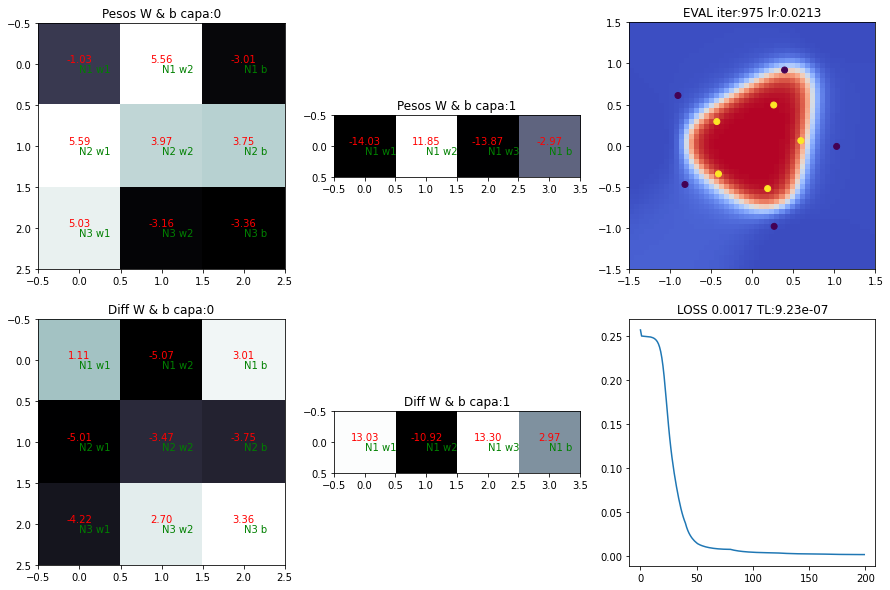

In [214]:
#@title proceso de RE-entrenamiento a partir de pesos optimos alterados
import time
from IPython.display import clear_output

CONTINUAR = True   # primer ciclo o continuacion

#random.seed(777)
#topologia = [p, 4, 8, 1]
#red = crea_nn(topologia, sigm)

#print(red.shape)
#red = []
#red.append(capa_neuronal(2, 4, sigm, 5))
#red.append(capa_neuronal(4, 8, sigm, 3))
#red.append(capa_neuronal(8, 1, sigm, 10))

#random.seed(888)

topologia = [p, 3, 1]
if(CONTINUAR!=True): red = crea_nn(topologia, sigm)

"""
WL1 = np.array([[ 8.84243203,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])
#WL1 = np.array([[ 1,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])

bL1 = np.array([[ 3.7654632 , -3.25091011, -2.91781571]])
#bL1 = np.array([[ -2 , -3.25091011, -2.91781571]])

WL2 = np.array([[ 14.3519784 ],  [-18.93268329],  [-17.98428509]])
#WL2 = np.array([[ 3.3519784 ],  [-18.93268329],  [-17.98428509]])

bL2 = np.array([[-2.53003652]])
bL2 = np.array([[0.53003652]])

red[0].W, red[0].b = WL1, bL1
red[1].W, red[1].b = WL2, bL2
"""

if(CONTINUAR!=True): red[0].shot()
if(CONTINUAR!=True): red[1].shot()

#red[0].rollback()
#red[1].rollback()


lr = LR = 0.85
iter = 1000
TL = 0

if(CONTINUAR!=True): loss = []
if(CONTINUAR!=True): frames = []

if(CONTINUAR!=True): L1 = []
if(CONTINUAR!=True): L2 = []

for i in range(iter):
  if(TL<1e-3): lr = LR * (1-i/iter)
  Py = train(red, X_coord, Y_class, l2_cost, lr)     # entrenamiento


  if i%25 ==0:
    loss.append(l2_cost[0](Py, Y_class))      # LOSS del entrenamiento

    L1.append(red[0].backup())
    L2.append(red[1].backup())

    #EVAL
    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)
    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train(red, np.array([[x0, x1]]), Y_class, l2_cost, train=False)[0,0]   # verificacion


    # IMPRIME GRAFICO
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    clear_output(wait=True)

    #fig, ax = plt.subplots()
    for l, Nlayer in enumerate(red):
      #layer = Nlayer.W.copy()
      #layer[0].append(Nlayer[0].b)
      layer = np.concatenate((Nlayer.W, Nlayer.b), axis=0)

      ax[0,l].set_title(f'Pesos W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[0,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[0,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'
      #ax[1,l].imshow(layer.b, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[0,l].text(a, b, '')











    for l, Nlayer in enumerate(red):
      layer = np.concatenate((Nlayer.W_i - Nlayer.W, Nlayer.b_i - Nlayer.b), axis=0)

      ax[1,l].set_title(f'Diff W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[1,l].text(a, b, '{:.3f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[1,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[1,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[1,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[1,l].text(a, b, '')




    ax[0,2].set_title(f'EVAL iter:{i} lr:{lr:.4f}')
    ax[0,2].pcolormesh(_x0, _x1, _Y, cmap="coolwarm")           # imprime la malla de resultados de la verificacion
    ax[0,2].axis("equal")

    #plt.scatter(X_coord[:,0], X_coord[:,1], c=Y_class)
    ax[0,2].scatter(X_coord[:,0], X_coord[:,1], c=Y_class)      # imprime los puntos

    #plt.show()
    TL = loss[-2]-loss[-1] if i>50 else 0
    ax[1,2].set_title(f'LOSS {loss[-1]:.4f} TL:{TL:.2e}')
    ax[1,2].plot(range(len(loss)), loss)                        # imprime el loss
    #plt.show()

    # FRAMES PARA VIDEO
    figu = plt.gcf()
    figu.canvas.draw()
    image = np.frombuffer(figu.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(figu.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.show()

    #time.sleep(1)

# Muestra el video
#media.show_video(frames, fps=3)

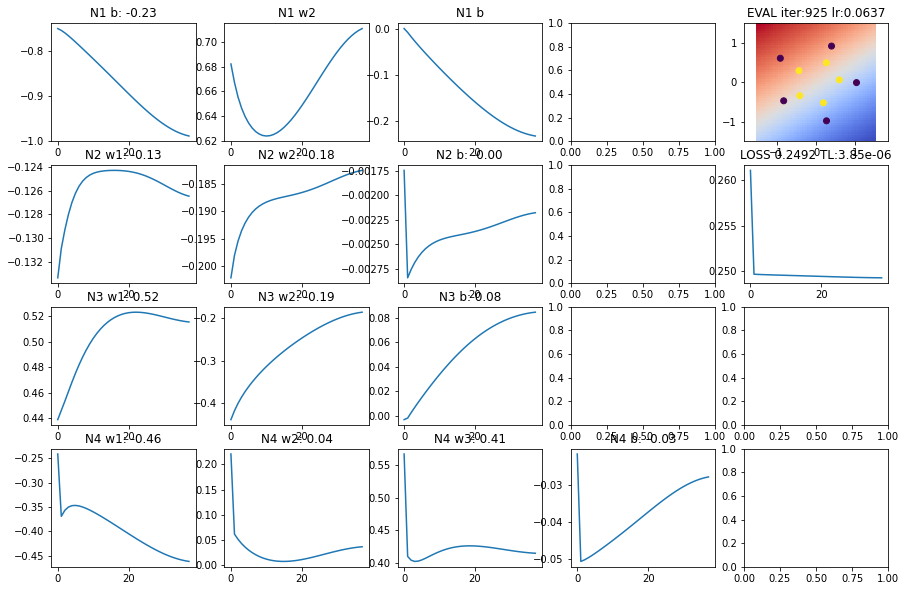

KeyboardInterrupt: ignored

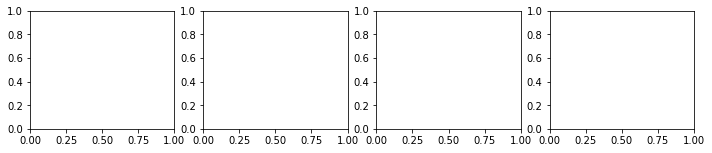

In [251]:
#@title GRAFICA DETALLADA proceso de RE-entrenamiento a partir de pesos optimos alterados
import time
from IPython.display import clear_output

CONTINUAR = False   # primer ciclo o continuacion

#random.seed(777)
#topologia = [p, 4, 8, 1]
#red = crea_nn(topologia, sigm)

#print(red.shape)
#red = []
#red.append(capa_neuronal(2, 4, sigm, 5))
#red.append(capa_neuronal(4, 8, sigm, 3))
#red.append(capa_neuronal(8, 1, sigm, 10))

#random.seed(888)

topologia = [p, 3, 1]
if(CONTINUAR!=True): red = crea_nn(topologia, sigm)

"""
WL1 = np.array([[ 8.84243203,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])
#WL1 = np.array([[ 1,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])

bL1 = np.array([[ 3.7654632 , -3.25091011, -2.91781571]])
#bL1 = np.array([[ -2 , -3.25091011, -2.91781571]])

WL2 = np.array([[ 14.3519784 ],  [-18.93268329],  [-17.98428509]])
#WL2 = np.array([[ 3.3519784 ],  [-18.93268329],  [-17.98428509]])

bL2 = np.array([[-2.53003652]])
bL2 = np.array([[0.53003652]])

red[0].W, red[0].b = WL1, bL1
red[1].W, red[1].b = WL2, bL2
"""

if(CONTINUAR!=True): red[0].shot()
if(CONTINUAR!=True): red[1].shot()

#red[0].rollback()
#red[1].rollback()


lr = LR = 0.85
iter = 1000
TL = 0

if(CONTINUAR!=True): loss = []
if(CONTINUAR!=True): frames = []

if(CONTINUAR!=True): L1 = []
if(CONTINUAR!=True): L2 = []


W1 = []
W2 = []
W3 = []
W4 = []
W5 = []
W6 = []
W7 = []
W8 = []
W9 = []
B1 = []
B2 = []
B3 = []
B4 = []


for i in range(iter):
  if(TL<1e-3): lr = LR * (1-i/iter)
  Py = train(red, X_coord, Y_class, l2_cost, lr)     # entrenamiento


  if i%25 ==0:
    loss.append(l2_cost[0](Py, Y_class))      # LOSS del entrenamiento

    #L1.append(red[0].backup())
    #L2.append(red[1].backup())

    #EVAL
    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)
    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train(red, np.array([[x0, x1]]), Y_class, l2_cost, train=False)[0,0]   # verificacion

    """
    # IMPRIME GRAFICO
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    clear_output(wait=True)

    #fig, ax = plt.subplots()
    for l, Nlayer in enumerate(red):
      #layer = Nlayer.W.copy()
      #layer[0].append(Nlayer[0].b)
      layer = np.concatenate((Nlayer.W, Nlayer.b), axis=0)

      ax[0,l].set_title(f'Pesos W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[0,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[0,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'
      #ax[1,l].imshow(layer.b, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[0,l].text(a, b, '')

      """








    """
    for l, Nlayer in enumerate(red):
      layer = np.concatenate((Nlayer.W_i - Nlayer.W, Nlayer.b_i - Nlayer.b), axis=0)

      ax[1,l].set_title(f'Diff W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[1,l].text(a, b, '{:.3f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[1,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[1,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[1,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[1,l].text(a, b, '')
      """


    layer = red[0]
    W1.append(layer.W[0][0])
    W2.append(layer.W[1][0])
    B1.append(layer.b[0][0])

    W3.append(layer.W[0][1])
    W4.append(layer.W[1][1])
    B2.append(layer.b[0][1])

    W5.append(layer.W[0][2])
    W6.append(layer.W[1][2])
    B3.append(layer.b[0][2])

    layer = red[1]
    W7.append(layer.W[0][0])
    W8.append(layer.W[1][0])
    W9.append(layer.W[2][0])
    B4.append(layer.b[0][0])

    # IMPRIME GRAFICO
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
    clear_output(wait=True)


    #ax[0,0].text('{:.2f}'.format(W1[-1]), ha='center', va='bottom', color='red')
    #ax[0,0].text(f'N{1} w{1}', ha='left', va='top', color='green')
    ax[0,0].set_title(f"N1 w1: {W1[-1]:.2f}")
    ax[0,0].plot(W1, label='W1')
    ax[0,1].set_title("N1 w2")
    ax[0,0].set_title(f"N1 w2: {W2[-1]:.2f}")
    ax[0,1].plot(W2, label='W2')
    ax[0,2].set_title("N1 b")
    ax[0,0].set_title(f"N1 b: {B1[-1]:.2f}")
    ax[0,2].plot(B1, label='b1')

    ax[1,0].set_title(f"N2 w1: {W3[-1]:.2f}")
    ax[1,0].plot(W3, label='W3')
    ax[1,1].set_title(f"N2 w2: {W4[-1]:.2f}")
    ax[1,1].plot(W4, label='W4')
    ax[1,2].set_title(f"N2 b: {B2[-1]:.2f}")
    ax[1,2].plot(B2, label='b2')

    ax[2,0].set_title(f"N3 w1: {W5[-1]:.2f}")
    ax[2,0].plot(W5, label='W5')
    ax[2,1].set_title(f"N3 w2: {W6[-1]:.2f}")
    ax[2,1].plot(W6, label='W6')
    ax[2,2].set_title(f"N3 b: {B3[-1]:.2f}")
    ax[2,2].plot(B3, label='b3')
    #ax[0,0].legend(loc='lower right')
    #plt.show()

    ax[3,0].set_title(f"N4 w1: {W7[-1]:.2f}")
    ax[3,0].plot(W7, label='W7')
    ax[3,1].set_title(f"N4 w2: {W8[-1]:.2f}")
    ax[3,1].plot(W8, label='W8')
    ax[3,2].set_title(f"N4 w3: {W9[-1]:.2f}")
    ax[3,2].plot(W9, label='W9')
    ax[3,3].set_title(f"N4 b: {B4[-1]:.2f}")
    ax[3,3].plot(B4, label='b4')
    #ax[0,0].legend(loc='lower right')
    #plt.show()





    ax[0,4].set_title(f'EVAL iter:{i} lr:{lr:.4f}')
    ax[0,4].pcolormesh(_x0, _x1, _Y, cmap="coolwarm")           # imprime la malla de resultados de la verificacion
    ax[0,4].axis("equal")

    #plt.scatter(X_coord[:,0], X_coord[:,1], c=Y_class)
    ax[0,4].scatter(X_coord[:,0], X_coord[:,1], c=Y_class)      # imprime los puntos

    #plt.show()
    TL = loss[-2]-loss[-1] if i>50 else 0
    ax[1,4].set_title(f'LOSS {loss[-1]:.4f} TL:{TL:.2e}')
    ax[1,4].plot(range(len(loss)), loss)                        # imprime el loss
    #plt.show()

    """
    # FRAMES PARA VIDEO
    figu = plt.gcf()
    figu.canvas.draw()
    image = np.frombuffer(figu.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(figu.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    """

    plt.show()

    #time.sleep(1)

# Muestra el video
#media.show_video(frames, fps=3)

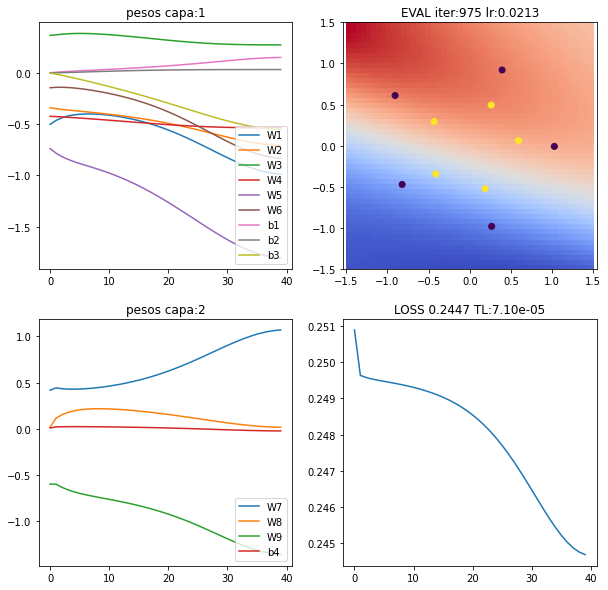

In [252]:
#@title GRAFICA UNIDA  proceso de RE-entrenamiento a partir de pesos optimos alterados
import time
from IPython.display import clear_output

CONTINUAR = False   # primer ciclo o continuacion

#random.seed(777)
#topologia = [p, 4, 8, 1]
#red = crea_nn(topologia, sigm)

#print(red.shape)
#red = []
#red.append(capa_neuronal(2, 4, sigm, 5))
#red.append(capa_neuronal(4, 8, sigm, 3))
#red.append(capa_neuronal(8, 1, sigm, 10))

#random.seed(888)

topologia = [p, 3, 1]
if(CONTINUAR!=True): red = crea_nn(topologia, sigm)

"""
WL1 = np.array([[ 8.84243203,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])
#WL1 = np.array([[ 1,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])

bL1 = np.array([[ 3.7654632 , -3.25091011, -2.91781571]])
#bL1 = np.array([[ -2 , -3.25091011, -2.91781571]])

WL2 = np.array([[ 14.3519784 ],  [-18.93268329],  [-17.98428509]])
#WL2 = np.array([[ 3.3519784 ],  [-18.93268329],  [-17.98428509]])

bL2 = np.array([[-2.53003652]])
bL2 = np.array([[0.53003652]])

red[0].W, red[0].b = WL1, bL1
red[1].W, red[1].b = WL2, bL2
"""

if(CONTINUAR!=True): red[0].shot()
if(CONTINUAR!=True): red[1].shot()

#red[0].rollback()
#red[1].rollback()


lr = LR = 0.85
iter = 1000
TL = 0

if(CONTINUAR!=True): loss = []
if(CONTINUAR!=True): frames = []

if(CONTINUAR!=True): L1 = []
if(CONTINUAR!=True): L2 = []


W1 = []
W2 = []
W3 = []
W4 = []
W5 = []
W6 = []
W7 = []
W8 = []
W9 = []
B1 = []
B2 = []
B3 = []
B4 = []


for i in range(iter):
  if(TL<1e-3): lr = LR * (1-i/iter)
  Py = train(red, X_coord, Y_class, l2_cost, lr)     # entrenamiento


  if i%25 ==0:
    loss.append(l2_cost[0](Py, Y_class))      # LOSS del entrenamiento

    #L1.append(red[0].backup())
    #L2.append(red[1].backup())

    #EVAL
    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)
    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train(red, np.array([[x0, x1]]), Y_class, l2_cost, train=False)[0,0]   # verificacion

    """
    # IMPRIME GRAFICO
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    clear_output(wait=True)

    #fig, ax = plt.subplots()
    for l, Nlayer in enumerate(red):
      #layer = Nlayer.W.copy()
      #layer[0].append(Nlayer[0].b)
      layer = np.concatenate((Nlayer.W, Nlayer.b), axis=0)

      ax[0,l].set_title(f'Pesos W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[0,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[0,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'
      #ax[1,l].imshow(layer.b, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[0,l].text(a, b, '')

      """








    """
    for l, Nlayer in enumerate(red):
      layer = np.concatenate((Nlayer.W_i - Nlayer.W, Nlayer.b_i - Nlayer.b), axis=0)

      ax[1,l].set_title(f'Diff W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[1,l].text(a, b, '{:.3f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[1,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[1,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[1,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[1,l].text(a, b, '')
      """


    layer = red[0]
    W1.append(layer.W[0][0])
    W2.append(layer.W[1][0])
    B1.append(layer.b[0][0])

    W3.append(layer.W[0][1])
    W4.append(layer.W[1][1])
    B2.append(layer.b[0][1])

    W5.append(layer.W[0][2])
    W6.append(layer.W[1][2])
    B3.append(layer.b[0][2])

    layer = red[1]
    W7.append(layer.W[0][0])
    W8.append(layer.W[1][0])
    W9.append(layer.W[2][0])
    B4.append(layer.b[0][0])

    # IMPRIME GRAFICO
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    clear_output(wait=True)


    ax[0,0].set_title("pesos capa:1")
    ax[0,0].plot(W1, label='W1')
    ax[0,0].plot(W2, label='W2')
    ax[0,0].plot(W3, label='W3')
    ax[0,0].plot(W4, label='W4')
    ax[0,0].plot(W5, label='W5')
    ax[0,0].plot(W6, label='W6')
    ax[0,0].plot(B1, label='b1')
    ax[0,0].plot(B2, label='b2')
    ax[0,0].plot(B3, label='b3')
    ax[0,0].legend(loc='lower right')

    ax[1,0].set_title("pesos capa:2")
    ax[1,0].plot(W7, label='W7')
    ax[1,0].plot(W8, label='W8')
    ax[1,0].plot(W9, label='W9')
    ax[1,0].plot(B4, label='b4')
    ax[1,0].legend(loc='lower right')




    ax[0,1].set_title(f'EVAL iter:{i} lr:{lr:.4f}')
    ax[0,1].pcolormesh(_x0, _x1, _Y, cmap="coolwarm")           # imprime la malla de resultados de la verificacion
    ax[0,1].axis("equal")

    #plt.scatter(X_coord[:,0], X_coord[:,1], c=Y_class)
    ax[0,1].scatter(X_coord[:,0], X_coord[:,1], c=Y_class)      # imprime los puntos

    #plt.show()
    TL = loss[-2]-loss[-1] if i>50 else 0
    ax[1,1].set_title(f'LOSS {loss[-1]:.4f} TL:{TL:.2e}')
    ax[1,1].plot(range(len(loss)), loss)                        # imprime el loss
    #plt.show()

    """
    # FRAMES PARA VIDEO
    figu = plt.gcf()
    figu.canvas.draw()
    image = np.frombuffer(figu.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(figu.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    """

    plt.show()

    #time.sleep(1)

# Muestra el video
#media.show_video(frames, fps=3)

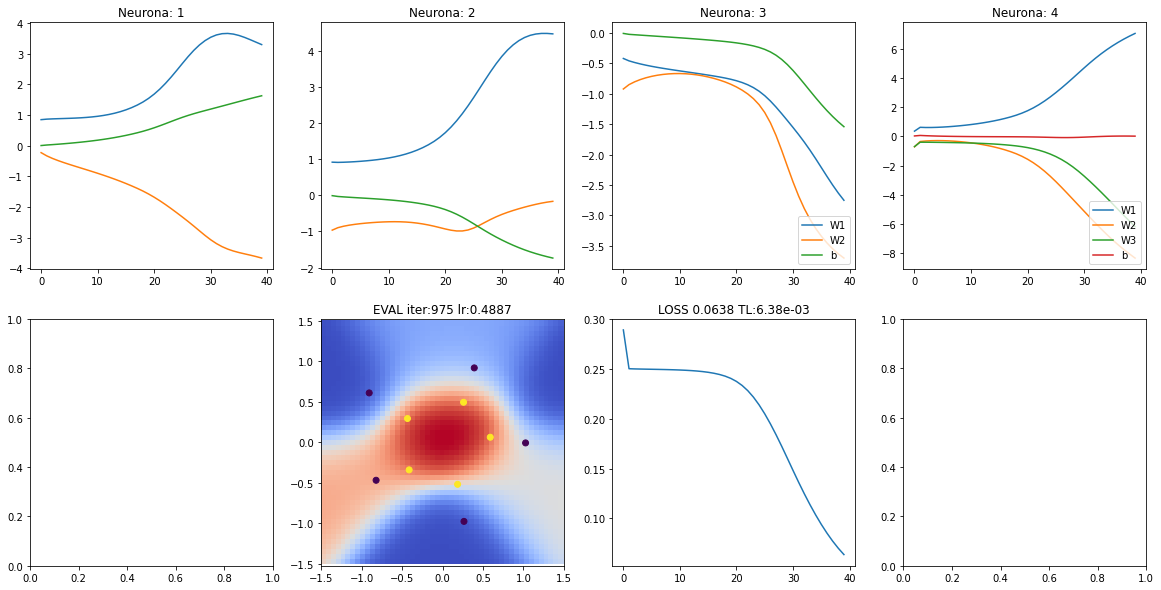

In [261]:
#@title GRAFICA x NEURONA  proceso de RE-entrenamiento a partir de pesos optimos alterados
import time
from IPython.display import clear_output

CONTINUAR = False   # primer ciclo o continuacion

#random.seed(777)
#topologia = [p, 4, 8, 1]
#red = crea_nn(topologia, sigm)

#print(red.shape)
#red = []
#red.append(capa_neuronal(2, 4, sigm, 5))
#red.append(capa_neuronal(4, 8, sigm, 3))
#red.append(capa_neuronal(8, 1, sigm, 10))

#random.seed(888)

topologia = [p, 3, 1]
if(CONTINUAR!=True): red = crea_nn(topologia, sigm)

"""
WL1 = np.array([[ 8.84243203,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])
#WL1 = np.array([[ 1,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])

bL1 = np.array([[ 3.7654632 , -3.25091011, -2.91781571]])
#bL1 = np.array([[ -2 , -3.25091011, -2.91781571]])

WL2 = np.array([[ 14.3519784 ],  [-18.93268329],  [-17.98428509]])
#WL2 = np.array([[ 3.3519784 ],  [-18.93268329],  [-17.98428509]])

bL2 = np.array([[-2.53003652]])
bL2 = np.array([[0.53003652]])

red[0].W, red[0].b = WL1, bL1
red[1].W, red[1].b = WL2, bL2
"""

if(CONTINUAR!=True): red[0].shot()
if(CONTINUAR!=True): red[1].shot()

#red[0].rollback()
#red[1].rollback()


lr = LR = 0.85
iter = 1000
TL = 0

if(CONTINUAR!=True): loss = []
if(CONTINUAR!=True): frames = []

if(CONTINUAR!=True): L1 = []
if(CONTINUAR!=True): L2 = []


W1 = []
W2 = []
W3 = []
W4 = []
W5 = []
W6 = []
W7 = []
W8 = []
W9 = []
B1 = []
B2 = []
B3 = []
B4 = []


for i in range(iter):
  if(TL<1e-3): lr = LR * (1-i/iter)
  Py = train(red, X_coord, Y_class, l2_cost, lr)     # entrenamiento


  if i%25 ==0:
    loss.append(l2_cost[0](Py, Y_class))      # LOSS del entrenamiento

    #L1.append(red[0].backup())
    #L2.append(red[1].backup())

    #EVAL
    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)
    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train(red, np.array([[x0, x1]]), Y_class, l2_cost, train=False)[0,0]   # verificacion

    """
    # IMPRIME GRAFICO
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    clear_output(wait=True)

    #fig, ax = plt.subplots()
    for l, Nlayer in enumerate(red):
      #layer = Nlayer.W.copy()
      #layer[0].append(Nlayer[0].b)
      layer = np.concatenate((Nlayer.W, Nlayer.b), axis=0)

      ax[0,l].set_title(f'Pesos W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[0,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[0,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'
      #ax[1,l].imshow(layer.b, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[0,l].text(a, b, '')

      """








    """
    for l, Nlayer in enumerate(red):
      layer = np.concatenate((Nlayer.W_i - Nlayer.W, Nlayer.b_i - Nlayer.b), axis=0)

      ax[1,l].set_title(f'Diff W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[1,l].text(a, b, '{:.3f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[1,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[1,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[1,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[1,l].text(a, b, '')
      """


    layer = red[0]
    W1.append(layer.W[0][0])
    W2.append(layer.W[1][0])
    B1.append(layer.b[0][0])

    W3.append(layer.W[0][1])
    W4.append(layer.W[1][1])
    B2.append(layer.b[0][1])

    W5.append(layer.W[0][2])
    W6.append(layer.W[1][2])
    B3.append(layer.b[0][2])

    layer = red[1]
    W7.append(layer.W[0][0])
    W8.append(layer.W[1][0])
    W9.append(layer.W[2][0])
    B4.append(layer.b[0][0])

    # IMPRIME GRAFICO
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    clear_output(wait=True)


    ax[0,0].set_title("Neurona: 1")
    ax[0,0].plot(W1, label='W1')
    ax[0,0].plot(W2, label='W2')
    ax[0,0].plot(B1, label='b1')

    ax[0,1].set_title("Neurona: 2")
    ax[0,1].plot(W3, label='W3')
    ax[0,1].plot(W4, label='W4')
    ax[0,1].plot(B2, label='b2')

    ax[0,2].set_title("Neurona: 3")
    ax[0,2].plot(W5, label='W1')
    ax[0,2].plot(W6, label='W2')
    ax[0,2].plot(B3, label='b')
    ax[0,2].legend(loc='lower right')

    ax[0,3].set_title("Neurona: 4")
    ax[0,3].plot(W7, label='W1')
    ax[0,3].plot(W8, label='W2')
    ax[0,3].plot(W9, label='W3')
    ax[0,3].plot(B4, label='b')
    ax[0,3].legend(loc='lower right')




    ax[1,1].set_title(f'EVAL iter:{i} lr:{lr:.4f}')
    ax[1,1].pcolormesh(_x0, _x1, _Y, cmap="coolwarm")           # imprime la malla de resultados de la verificacion
    ax[1,1].axis("equal")

    #plt.scatter(X_coord[:,0], X_coord[:,1], c=Y_class)
    ax[1,1].scatter(X_coord[:,0], X_coord[:,1], c=Y_class)      # imprime los puntos

    #plt.show()
    TL = loss[-2]-loss[-1] if i>50 else 0
    ax[1,2].set_title(f'LOSS {loss[-1]:.4f} TL:{TL:.2e}')
    ax[1,2].plot(range(len(loss)), loss)                        # imprime el loss
    #plt.show()

    """
    # FRAMES PARA VIDEO
    figu = plt.gcf()
    figu.canvas.draw()
    image = np.frombuffer(figu.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(figu.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    """

    plt.show()

    #time.sleep(1)

# Muestra el video
#media.show_video(frames, fps=3)

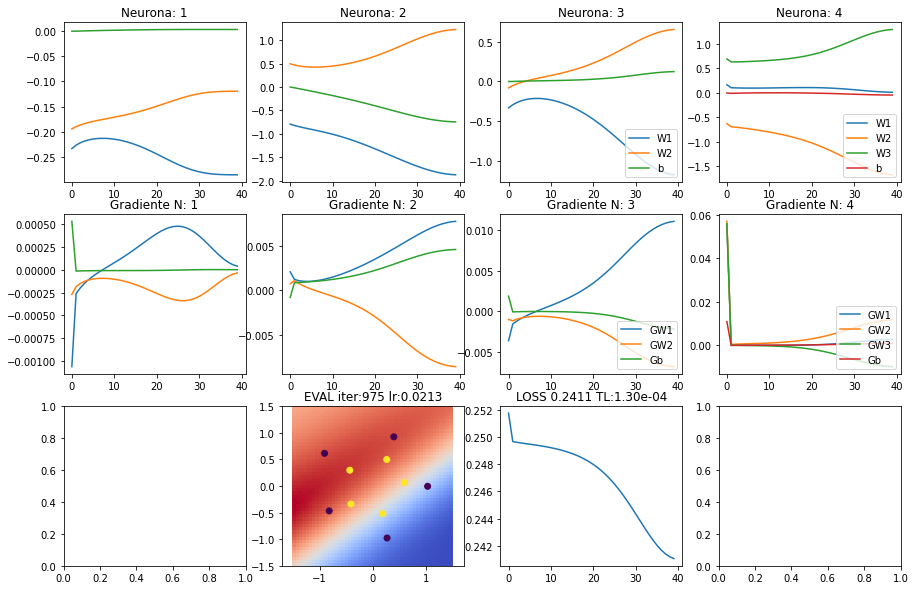

In [265]:
#@title GRAFICA x NEURONA y GRADIENTE proceso de RE-entrenamiento a partir de pesos optimos alterados
import time
from IPython.display import clear_output

CONTINUAR = False   # primer ciclo o continuacion

#random.seed(777)
#topologia = [p, 4, 8, 1]
#red = crea_nn(topologia, sigm)

#print(red.shape)
#red = []
#red.append(capa_neuronal(2, 4, sigm, 5))
#red.append(capa_neuronal(4, 8, sigm, 3))
#red.append(capa_neuronal(8, 1, sigm, 10))

#random.seed(888)

topologia = [p, 3, 1]
if(CONTINUAR!=True): red = crea_nn(topologia, sigm)

"""
WL1 = np.array([[ 8.84243203,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])
#WL1 = np.array([[ 1,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])

bL1 = np.array([[ 3.7654632 , -3.25091011, -2.91781571]])
#bL1 = np.array([[ -2 , -3.25091011, -2.91781571]])

WL2 = np.array([[ 14.3519784 ],  [-18.93268329],  [-17.98428509]])
#WL2 = np.array([[ 3.3519784 ],  [-18.93268329],  [-17.98428509]])

bL2 = np.array([[-2.53003652]])
bL2 = np.array([[0.53003652]])

red[0].W, red[0].b = WL1, bL1
red[1].W, red[1].b = WL2, bL2
"""

if(CONTINUAR!=True): red[0].shot()
if(CONTINUAR!=True): red[1].shot()

#red[0].rollback()
#red[1].rollback()


lr = LR = 0.85
iter = 1000
TL = 0

if(CONTINUAR!=True): loss = []
if(CONTINUAR!=True): frames = []

if(CONTINUAR!=True): L1 = []
if(CONTINUAR!=True): L2 = []


W1 = []
W2 = []
W3 = []
W4 = []
W5 = []
W6 = []
W7 = []
W8 = []
W9 = []
B1 = []
B2 = []
B3 = []
B4 = []


GW1 = []
GW2 = []
GW3 = []
GW4 = []
GW5 = []
GW6 = []
GW7 = []
GW8 = []
GW9 = []
GB1 = []
GB2 = []
GB3 = []
GB4 = []


for i in range(iter):
  if(TL<1e-3): lr = LR * (1-i/iter)
  Py = train(red, X_coord, Y_class, l2_cost, lr)     # entrenamiento


  if i%25 ==0:
    loss.append(l2_cost[0](Py, Y_class))      # LOSS del entrenamiento

    #L1.append(red[0].backup())
    #L2.append(red[1].backup())

    #EVAL
    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)
    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train(red, np.array([[x0, x1]]), Y_class, l2_cost, train=False)[0,0]   # verificacion

    """
    # IMPRIME GRAFICO
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    clear_output(wait=True)

    #fig, ax = plt.subplots()
    for l, Nlayer in enumerate(red):
      #layer = Nlayer.W.copy()
      #layer[0].append(Nlayer[0].b)
      layer = np.concatenate((Nlayer.W, Nlayer.b), axis=0)

      ax[0,l].set_title(f'Pesos W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[0,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[0,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'
      #ax[1,l].imshow(layer.b, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[0,l].text(a, b, '')

      """








    """
    for l, Nlayer in enumerate(red):
      layer = np.concatenate((Nlayer.W_i - Nlayer.W, Nlayer.b_i - Nlayer.b), axis=0)

      ax[1,l].set_title(f'Diff W & b capa:{l}')
      #pone numeros
      ##for a in range(layer.shape[0]): #layer.W.shape[0]):
      ##  for b in range(layer.shape[1]): #layer.W.shape[1]):
      ##      ax[1,l].text(a, b, '{:.3f}'.format(layer[a, b]), ha='center', va='center', color='red')

      for a in range(layer.shape[0]): #layer.W.shape[0]):
        last = layer.shape[0]-1
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            #ha: 'center', 'right', 'left'
            #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            ax[1,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
            ww = "b"
            if a<last : ww = f"w{a+1}"
            ax[1,l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

      #imprime    
      #ax.matshow(layer.W)
      ax[1,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[1,l].text(a, b, '')
      """

    #PESOS W y B
    layer = red[0]
    W1.append(layer.W[0][0])
    W2.append(layer.W[1][0])
    B1.append(layer.b[0][0])

    W3.append(layer.W[0][1])
    W4.append(layer.W[1][1])
    B2.append(layer.b[0][1])

    W5.append(layer.W[0][2])
    W6.append(layer.W[1][2])
    B3.append(layer.b[0][2])

    layer = red[1]
    W7.append(layer.W[0][0])
    W8.append(layer.W[1][0])
    W9.append(layer.W[2][0])
    B4.append(layer.b[0][0])


    # GRADIENTES
    layer = red[0]
    GW1.append(layer.grad_W[0][0])
    GW2.append(layer.grad_W[1][0])
    GB1.append(layer.grad_b[0][0])

    GW3.append(layer.grad_W[0][1])
    GW4.append(layer.grad_W[1][1])
    GB2.append(layer.grad_b[0][1])

    GW5.append(layer.grad_W[0][2])
    GW6.append(layer.grad_W[1][2])
    GB3.append(layer.grad_b[0][2])

    layer = red[1]
    GW7.append(layer.grad_W[0][0])
    GW8.append(layer.grad_W[1][0])
    GW9.append(layer.grad_W[2][0])
    GB4.append(layer.grad_b[0][0])


    # IMPRIME GRAFICO
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
    clear_output(wait=True)


    # IMPRIME NEURONAS
    ax[0,0].set_title("Neurona: 1")
    ax[0,0].plot(W1, label='W1')
    ax[0,0].plot(W2, label='W2')
    ax[0,0].plot(B1, label='b1')

    ax[0,1].set_title("Neurona: 2")
    ax[0,1].plot(W3, label='W3')
    ax[0,1].plot(W4, label='W4')
    ax[0,1].plot(B2, label='b2')

    ax[0,2].set_title("Neurona: 3")
    ax[0,2].plot(W5, label='W1')
    ax[0,2].plot(W6, label='W2')
    ax[0,2].plot(B3, label='b')
    ax[0,2].legend(loc='lower right')

    ax[0,3].set_title("Neurona: 4")
    ax[0,3].plot(W7, label='W1')
    ax[0,3].plot(W8, label='W2')
    ax[0,3].plot(W9, label='W3')
    ax[0,3].plot(B4, label='b')
    ax[0,3].legend(loc='lower right')


    # IMPRIME GRADIENTES
    ax[1,0].set_title("Gradiente N: 1")
    ax[1,0].plot(GW1, label='W1')
    ax[1,0].plot(GW2, label='W2')
    ax[1,0].plot(GB1, label='b1')

    ax[1,1].set_title("Gradiente N: 2")
    ax[1,1].plot(GW3, label='W3')
    ax[1,1].plot(GW4, label='W4')
    ax[1,1].plot(GB2, label='b2')

    ax[1,2].set_title("Gradiente N: 3")
    ax[1,2].plot(GW5, label='GW1')
    ax[1,2].plot(GW6, label='GW2')
    ax[1,2].plot(GB3, label='Gb')
    ax[1,2].legend(loc='lower right')

    ax[1,3].set_title("Gradiente N: 4")
    ax[1,3].plot(GW7, label='GW1')
    ax[1,3].plot(GW8, label='GW2')
    ax[1,3].plot(GW9, label='GW3')
    ax[1,3].plot(GB4, label='Gb')
    ax[1,3].legend(loc='lower right')



    ax[2,1].set_title(f'EVAL iter:{i} lr:{lr:.4f}')
    ax[2,1].pcolormesh(_x0, _x1, _Y, cmap="coolwarm")           # imprime la malla de resultados de la verificacion
    ax[2,1].axis("equal")

    #plt.scatter(X_coord[:,0], X_coord[:,1], c=Y_class)
    ax[2,1].scatter(X_coord[:,0], X_coord[:,1], c=Y_class)      # imprime los puntos

    #plt.show()
    TL = loss[-2]-loss[-1] if i>50 else 0
    ax[2,2].set_title(f'LOSS {loss[-1]:.4f} TL:{TL:.2e}')
    ax[2,2].plot(range(len(loss)), loss)                        # imprime el loss
    #plt.show()

    """
    # FRAMES PARA VIDEO
    figu = plt.gcf()
    figu.canvas.draw()
    image = np.frombuffer(figu.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(figu.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    """

    plt.show()

    #time.sleep(1)

# Muestra el video
#media.show_video(frames, fps=3)

In [ ]:
dir(ax[0,0])

In [262]:
ax[0,0].set_xlabel = "YY"

In [74]:
'{:.2f}'.format(0.1236456789), f"{0.0000456789:.2e}"

('0.12', '4.57e-05')

In [148]:
len(L1), "////",  L1[-1].delta, "////",  np.mean(L1[-1].delta, axis=0, keepdims=True)

(40, '////', array([[ 0.01620557, -0.02459202,  0.01108059],
        [ 0.01775528, -0.0164377 ,  0.01156548],
        [-0.01710409,  0.02056238, -0.01147303],
        [-0.01911902,  0.03086803, -0.01303725],
        [ 0.01756829, -0.03058938,  0.01228226],
        [ 0.02002944, -0.0142547 ,  0.01282283],
        [-0.01680386,  0.01799092, -0.01119107],
        [ 0.01569893, -0.01860794,  0.0097802 ],
        [-0.01743199,  0.028247  , -0.01200105],
        [-0.01886841,  0.02918078, -0.01249847]]), '////', array([[-0.00020699,  0.00223674, -0.00026695]]))

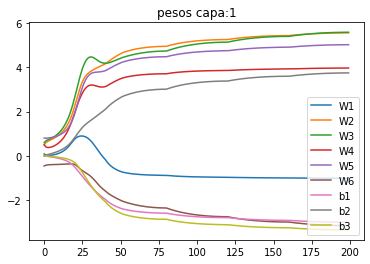

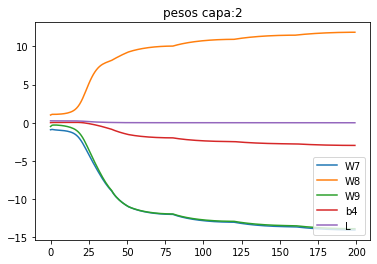

In [215]:
#@title Grafica de movimiento de pesos en proceso ajuste
W1 = []
W2 = []
W3 = []
W4 = []
W5 = []
W6 = []
W7 = []
W8 = []
W9 = []
B1 = []
B2 = []
B3 = []
B4 = []
L = []
for i, layer in enumerate(L1):
  #print(layer.W[0][0])
  W1.append(layer.W[0][0])
  W2.append(layer.W[1][0])
  B1.append(layer.b[0][0])

  W3.append(layer.W[0][1])
  W4.append(layer.W[1][1])
  B2.append(layer.b[0][1])

  W5.append(layer.W[0][2])
  W6.append(layer.W[1][2])
  B3.append(layer.b[0][2])

for i, layer in enumerate(L2):
  W7.append(layer.W[0][0])
  W8.append(layer.W[1][0])
  W9.append(layer.W[2][0])
  B4.append(layer.b[0][0])

  L.append(layer.loss)

#W1
plt.title("pesos capa:1")
plt.plot(W1, label='W1')
plt.plot(W2, label='W2')
plt.plot(W3, label='W3')
plt.plot(W4, label='W4')
plt.plot(W5, label='W5')
plt.plot(W6, label='W6')
plt.plot(B1, label='b1')
plt.plot(B2, label='b2')
plt.plot(B3, label='b3')
plt.legend(loc='lower right')
plt.show()

plt.title("pesos capa:2")
plt.plot(W7, label='W7')
plt.plot(W8, label='W8')
plt.plot(W9, label='W9')
plt.plot(B4, label='b4')
plt.plot(L, label='L')
plt.legend(loc='lower right')
plt.show()

#https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#sphx-glr-tutorials-intermediate-legend-guide-py
#plt.legend(loc='lower right')
#plt.legend(handles=[W1, W2, W3, W4], title=["W1", "W2", "W3", "W4"])

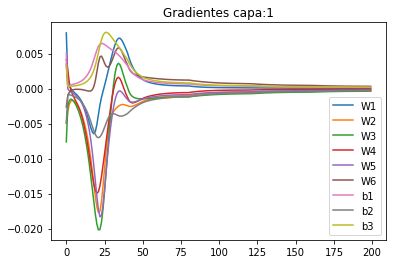

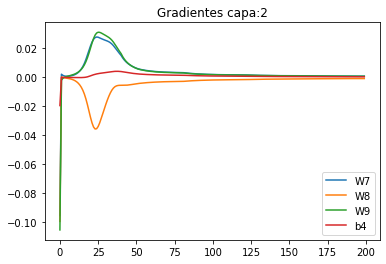

In [216]:
W1 = []
W2 = []
W3 = []
W4 = []
W5 = []
W6 = []
W7 = []
W8 = []
W9 = []
B1 = []
B2 = []
B3 = []
B4 = []
L = []
for i, layer in enumerate(L1):
  #print(layer.W[0][0])
  W1.append(layer.grad_W[0][0])
  W2.append(layer.grad_W[1][0])
  B1.append(layer.grad_b[0][0])

  W3.append(layer.grad_W[0][1])
  W4.append(layer.grad_W[1][1])
  B2.append(layer.grad_b[0][1])

  W5.append(layer.grad_W[0][2])
  W6.append(layer.grad_W[1][2])
  B3.append(layer.grad_b[0][2])

for i, layer in enumerate(L2):
  W7.append(layer.grad_W[0][0])
  W8.append(layer.grad_W[1][0])
  W9.append(layer.grad_W[2][0])
  B4.append(layer.grad_b[0][0])

  #L.append(layer.dloss)

#W1
plt.title("Gradientes capa:1")
plt.plot(W1, label='W1')
plt.plot(W2, label='W2')
plt.plot(W3, label='W3')
plt.plot(W4, label='W4')
plt.plot(W5, label='W5')
plt.plot(W6, label='W6')
plt.plot(B1, label='b1')
plt.plot(B2, label='b2')
plt.plot(B3, label='b3')
plt.legend(loc='lower right')
plt.show()

plt.title("Gradientes capa:2")
plt.plot(W7, label='W7')
plt.plot(W8, label='W8')
plt.plot(W9, label='W9')
plt.plot(B4, label='b4')
#plt.plot(L, label='L')
plt.legend(loc='lower right')
plt.show()


In [189]:
#@title ANALISIS RED POR ALTERACION DE CAPAS OPTIMAS
#https://ipywidgets.readthedocs.io/en/latest/index.html
#https://jupyterlite.readthedocs.io/en/latest/
#https://github.com/jupyter-widgets/tutorial
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout, VBox, HBox #  GridBox,
import ipywidgets as widgets
import time
from IPython.display import clear_output

topologia = [p, 3, 1]
#red = crea_nn(topologia, sigm)

L1_N1_W1 = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N1 w1') #, layout=Layout(width='70%'), style={'description_width': 'initial'}) #, layout=Layout(flex='1 1 0%', width='30%'), grid_area='N1')
L1_N1_W2 = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N1 w2')#, layout=Layout(width='auto'))  #, layout=Layout(flex='2 3 0%', width='30%'), grid_area='N1')
L1_N1_B  = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N1 b')#, layout=Layout(width='auto'))  #, layout=Layout(flex='1 1 0%', width='30%'), grid_area='N1')
L1_N2_W1 = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N2 w1')#, layout=Layout(width='auto'))  #, layout=Layout(display='inline-flex'))
L1_N2_W2 = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N2 w2')#, layout=Layout(width='100%'))  #, layout=Layout(display='inline-flex'))
L1_N2_B  = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N2 b')#, layout=Layout(width='auto'))  #, layout=Layout(display='inline-flex'))
L1_N3_W1 = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N3 w1')#, layout=Layout(width='auto'))  #, style={'description_width': 'initial'})
L1_N3_W2 = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N3 w2')#, layout=Layout(width='auto'))  #, style={'flex': 'flex-basis'})
L1_N3_B  = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N3 b')#, layout=Layout(width='auto'))  #, style={'flex': 'flex-basis', 'color': 'green'})
L2_N1_W1 = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N4 w1')#, layout=Layout(width='auto')) 
L2_N1_W2 = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N4 w2')#, layout=Layout(width='auto')) 
L2_N1_W3 = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N4 w3')#, layout=Layout(width='auto')) 
L2_N1_B  = widgets.FloatSlider(min=-20, max=20, step=0.01, value=5, continuous_update=False, description='N4 b')#, layout=Layout(width='auto')) 


"""
#                   N1w1          N2w1          N3w1           N1w2          N2w2          N3w2
WL1 = np.array([[ 8.84243203,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])
#WL1 = np.array([[ 1,  2.1386732 ,  2.94748844],   [ 0.78027067,  4.12606739, -4.23355456]])

#                   N1b           N2b         N3b
bL1 = np.array([[ 3.7654632 , -3.25091011, -2.91781571]])
#bL1 = np.array([[ -2 , -3.25091011, -2.91781571]])

#                   N4w1              N4w2            N4w3
WL2 = np.array([[ 14.3519784 ],  [-18.93268329],  [-17.98428509]])
#WL2 = np.array([[ 3.3519784 ],  [-18.93268329],  [-17.98428509]])

#                     N4b
bL2 = np.array([[-2.53003652]])
#bL2 = np.array([[0.53003652]])
"""

"""
L1_N1_W1.value = WL1[0][0]
L1_N1_W2.value = WL1[1][0]
L1_N1_B.value  = bL1[0][0]

L1_N2_W1.value = WL1[0][1]
L1_N2_W2.value = WL1[1][1]
L1_N2_B.value  = bL1[0][1]

L1_N3_W1.value = WL1[0][2]
L1_N3_W2.value = WL1[1][2]
L1_N3_B.value  = bL1[0][2]

L2_N1_W1.value = WL2[0][0]
L2_N1_W2.value = WL2[1][0]
L2_N1_W3.value = WL2[2][0]
L2_N1_B.value  = bL2[0][0]
"""
#                   Layer W  N
L1_N1_W1.value = red[0].W[0][0]  #WL1[0][0]
L1_N1_W2.value = red[0].W[1][0]  #WL1[1][0]
L1_N1_B.value  = red[0].b[0][0]  #bL1[0][0]

L1_N2_W1.value = red[0].W[0][1]  #WL1[0][1]
L1_N2_W2.value = red[0].W[1][1]  #WL1[1][1]
L1_N2_B.value  = red[0].b[0][1]  #bL1[0][1]

L1_N3_W1.value = red[0].W[0][2]  #WL1[0][2]
L1_N3_W2.value = red[0].W[1][2]  #WL1[1][2]
L1_N3_B.value  = red[0].b[0][2]  #bL1[0][2]

L2_N1_W1.value = red[1].W[0][0]  #WL2[0][0]
L2_N1_W2.value = red[1].W[1][0]  #WL2[1][0]
L2_N1_W3.value = red[1].W[2][0]  #WL2[2][0]
L2_N1_B.value  = red[1].b[0][0]  #bL2[0][0]



_x0 = None
_y0 = None
_X = np.array([[None, None]])

def update_plot(N1w1,N1w2,N1b,N2w1,N2w2,N2b,N3w1,N3w2,N3b,N4w1,N4w2,N4w3,N4b):
  global red
  red[0].W = np.array([[N1w1, N2w1, N3w1], [N1w2, N2w2, N3w2]])
  red[0].b = np.array([[N1b, N2b, N3b]])
  red[1].W = np.array([[N4w1], [N4w2], [N4w3]])
  red[1].b = np.array([[N4b]])
  print(red[0].W, red[0].b, red[1].W, red[1].b)

  #EVAL
  res = 50
  global _x0
  _x0 = np.linspace(-1.5, 1.5, res)
  global _x1
  _x1 = np.linspace(-1.55, 1.45, res)
  _Y = np.zeros((res, res))

  clear_output(wait=True)

  #global _X
  #_X = np.array([[None, None]])
  #_Y = [[None]]

  for i0, x0 in enumerate(_x0):
    for i1, x1 in enumerate(_x1):
      #_X[0].append([x0, x1])
      #_Y[0].append([x0])
      _Y[i0, i1] = train(red, np.array([[x0, x1]]), Y_class, l2_cost, train=False)[0,0]   # verificacion
      #print(f"[{x0}, {x1}] = {_Y[i0, i1]}")
  #print(len(_X[0]), _X.shape[0])


  # PREPARA GRAFICOS
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

  # IMPRIME MATRICES
  for l, Nlayer in enumerate(red):
    layer = np.concatenate((Nlayer.W, Nlayer.b), axis=0)

    ax[l].set_title(f'W & b capa:{l}')
    #pone numeros
    for a in range(layer.shape[0]): #layer.W.shape[0]):
      last = layer.shape[0]-1
      for b in range(layer.shape[1]): #layer.W.shape[1]):
        #ha: 'center', 'right', 'left'
        #va: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
          ax[l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='bottom', color='red')
          ww = "b"
          if a<last : ww = f"w{a+1}"
          ax[l].text(a, b, f'N{b+1} {ww}', ha='left', va='top', color='green')

    #imprime    
    #ax.matshow(layer.W)
    ax[l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

    #limpia
    for a in range(layer.shape[0]):
      for b in range(layer.shape[1]):
          ax[l].text(a, b, '')


  # IMPRIME GRAFICO 
  ax[2].set_title(f'EVAL samples:{res}')
  ax[2].pcolormesh(_x0, _x1, _Y, cmap="coolwarm")           # imprime la malla de resultados de la verificacion
  ax[2].axis("equal")
  ax[2].scatter(X_coord[:,0], X_coord[:,1], c=Y_class)      # imprime los puntos

  plt.show()

#interact(update_plot, N1w1=L1_N1_W1, N1w2=L1_N1_W2, N1b=L1_N1_B, N2w1=L1_N2_W1, N2w2=L1_N2_W2, N2b=L1_N2_B, N3w1=L1_N3_W1, N3w2=L1_N3_W2, N3b=L1_N3_B, N4w1=L2_N1_W1, N4w2=L2_N1_W2, N4w3=L2_N1_W3, N4b=L2_N1_B)

N1_box = widgets.VBox([L1_N1_W1, L1_N1_W2, L1_N1_B ])
N2_box = widgets.VBox([L1_N2_W1, L1_N2_W2, L1_N2_B ])
N3_box = widgets.VBox([L1_N3_W1, L1_N3_W2, L1_N3_B ])
N4_box = widgets.VBox([L2_N1_W1, L2_N1_W2, L2_N1_W3, L2_N1_B])

user_interface = widgets.HBox([N1_box, N2_box, N3_box, N4_box])
out = widgets.interactive_output(update_plot, {'N1w1':L1_N1_W1, 'N1w2':L1_N1_W2, 'N1b':L1_N1_B, 'N2w1':L1_N2_W1, 'N2w2':L1_N2_W2, 'N2b':L1_N2_B, 'N3w1':L1_N3_W1, 'N3w2':L1_N3_W2, 'N3b':L1_N3_B, 'N4w1':L2_N1_W1, 'N4w2':L2_N1_W2, 'N4w3':L2_N1_W3, 'N4b':L2_N1_B})
display(user_interface, out)


Output()

In [190]:
red[0].shot()
red[1].shot()

In [191]:
red[0].rollback()
red[1].rollback()

In [164]:
red[0].W = red[0].W_i.copy()
red[1].W = red[1].W_i.copy()


In [47]:
_X

array([[None, None]], dtype=object)

In [35]:
_x0, _x1,  np.linspace(-1.55, 1.45, 10)

(array([-1.5       , -1.16666667, -0.83333333, -0.5       , -0.16666667,
         0.16666667,  0.5       ,  0.83333333,  1.16666667,  1.5       ]),
 array([-1.5       , -1.16666667, -0.83333333, -0.5       , -0.16666667,
         0.16666667,  0.5       ,  0.83333333,  1.16666667,  1.5       ]),
 array([-1.55      , -1.21666667, -0.88333333, -0.55      , -0.21666667,
         0.11666667,  0.45      ,  0.78333333,  1.11666667,  1.45      ]))

In [ ]:
%whos

Variable          Type                Data/Info
-----------------------------------------------
L1_N1_B           FloatSlider         FloatSlider(value=3.76546<...>.0, min=-20.0, step=0.01)
L1_N1_W1          FloatSlider         FloatSlider(value=8.84243<...>.0, min=-20.0, step=0.01)
L1_N1_W2          FloatSlider         FloatSlider(value=0.78027<...>.0, min=-20.0, step=0.01)
L1_N2_B           FloatSlider         FloatSlider(value=-3.2509<...>.0, min=-20.0, step=0.01)
L1_N2_W1          FloatSlider         FloatSlider(value=2.13867<...>.0, min=-20.0, step=0.01)
L1_N2_W2          FloatSlider         FloatSlider(value=4.12606<...>.0, min=-20.0, step=0.01)
L1_N3_B           FloatSlider         FloatSlider(value=-3.29, <...>.0, min=-20.0, step=0.01)
L1_N3_W1          FloatSlider         FloatSlider(value=2.94748<...>.0, min=-20.0, step=0.01)
L1_N3_W2          FloatSlider         FloatSlider(value=-3.8, c<...>.0, min=-20.0, step=0.01)
L2_N1_B           FloatSlider         FloatSlider(value=-2

In [ ]:
#@title
a = widgets.IntSlider()
b = widgets.IntSlider()
c = widgets.IntSlider()
ui = widgets.HBox([a, b, c])
def f(a, b, c):
    print((a, b, c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})
#out = widgets.interactive(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

Output()

In [ ]:
#https://ipywidgets.readthedocs.io/en/latest/index.html
#https://jupyterlite.readthedocs.io/en/latest/
#https://github.com/jupyter-widgets/tutorial
#https://www.programcreek.com/python/example/90674/ipywidgets.IntSlider
#https://www.programcreek.com/python/?code=scqubits%2Fscqubits%2Fscqubits-master%2Fscqubits%2Fcore%2Fexplorer.py

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

x_widget = widgets.FloatSlider(min=0.0, max=10.0, step=0.05)
y_widget = widgets.FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)

def update_x_range(*args):
    x_widget.max = 2.0 * y_widget.value

y_widget.observe(update_x_range, 'value')

def printer(x, y):
    print(x, y)

interact(printer,x=x_widget, y=y_widget);


interactive(children=(FloatSlider(value=0.0, description='x', max=10.0, step=0.05), FloatSlider(value=5.0, des…

In [ ]:
#@title proceso de entrenamiento y test con video
import time
from IPython.display import clear_output

random.seed(777)
topologia = [p, 4, 8, 1]
#red = crea_nn(topologia, sigm)

#print(red.shape)
red = []
red.append(capa_neuronal(2, 4, sigm, 5))
red.append(capa_neuronal(4, 8, sigm, 3))
red.append(capa_neuronal(8, 1, sigm, 10))

loss = []
frames = []

for i in range(2000):
  Py = train(red, X_coord, Y_class, l2_cost, 0.5)     # entrenamiento

  if i%25 ==0:
    loss.append(l2_cost[0](Py, Y_class))      # LOSS del entrenamiento

    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)
    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train(red, np.array([[x0, x1]]), Y_class, l2_cost, train=False)[0,0]   # verificacion

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    #fig, ax = plt.subplots()
    for l, Nlayer in enumerate(red):
      #layer = Nlayer.W.copy()
      #layer[0].append(Nlayer[0].b)
      layer = np.concatenate((Nlayer.W, Nlayer.b), axis=0)

      ax[0,l].set_title(f'W & b capa:{l}')
      #pone numeros
      for a in range(layer.shape[0]): #layer.W.shape[0]):
        for b in range(layer.shape[1]): #layer.W.shape[1]):
            ax[0,l].text(a, b, '{:.2f}'.format(layer[a, b]), ha='center', va='center', color='red')

      #imprime    
      #ax.matshow(layer.W)
      ax[0,l].imshow(layer.T, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'
      #ax[1,l].imshow(layer.b, cmap='bone') # cmap='gray'   cmap='binary'  cmap='hot'

      #limpia
      for a in range(layer.shape[0]):
        for b in range(layer.shape[1]):
            ax[0,l].text(a, b, '')

    #plt.show()

    """
    #for l, layer in enumerate(red):
      #plt.matshow(layer.W)
    plt.show()
    """

    ax[1,0].set_title(f'EVAL iter:{i}')
    ax[1,0].pcolormesh(_x0, _x1, _Y, cmap="coolwarm")           # imprime la malla de resultados de la verificacion
    ax[1,0].axis("equal")

    #plt.scatter(X_coord[:,0], X_coord[:,1], c=Y_class)
    ax[1,0].scatter(X_coord[:,0], X_coord[:,1], c=Y_class)      # imprime los puntos

    clear_output(wait=True)
    #plt.show()
    ax[1,2].set_title(f'LOSS {loss[-1]} iter:{i}')
    ax[1,2].plot(range(len(loss)), loss)                        # imprime el loss
    #plt.show()

    # FRAMES PARA VIDEO
    figu = plt.gcf()
    figu.canvas.draw()
    image = np.frombuffer(figu.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(figu.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.show()

    #time.sleep(1)

# Muestra el video
#media.show_video(frames, fps=3)

In [ ]:
relu[0](-3)

0

In [ ]:
red[0].W

array([[ 1.90401014,  4.62566913, -1.09476949, -2.50862738],
       [ 3.57917139,  0.24109113, -3.02505216, -1.62772436]])

In [ ]:
vars(red[0])

{'n_entrada': 2,
 'n_salidas': 4,
 'func_activacion': <function __main__.<lambda>(x)>,
 'deriv_activacion': <function __main__.<lambda>(x)>,
 'b': array([[0., 0., 0., 0.]]),
 'W': array([[ 1.90401014,  4.62566913, -1.09476949, -2.50862738],
        [ 3.57917139,  0.24109113, -3.02505216, -1.62772436]]),
 'W_': [],
 'X': [],
 'neurona': [],
 'activa': [],
 'dactiva': [],
 'loss': [],
 'dloss': [],
 'dloss_back': [],
 'delta': [],
 'grad_W': [],
 'grad_b': []}

In [54]:
#@title  librerias Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media

Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.0 MB/s eta 0:00:00


In [217]:
#@title desplegar video
import mediapy as media
# Muestra el video
media.show_video(frames, fps=3)

In [ ]:
#@title
layer

array([[-0.11878377, -0.6561763 , -0.6834172 , -0.68873911],
       [ 0.66061351,  0.51964402, -0.33897284,  0.96597544],
       [ 0.03074625, -0.23378311, -0.23948108,  0.2084533 ]])

In [ ]:
#@title
Nlayer.b

array([[ 0.03074625, -0.23378311, -0.23948108,  0.2084533 ]])

In [ ]:
#@title
for l, layer in enumerate(red):
  print (layer.W)

[[ 0.91443482 -0.68711245  0.07775442 -0.79371103]
 [ 0.20993999  0.57737834  0.83419131 -0.55221335]]
[[ 0.91911512  0.47607804 -0.78071436  0.44327654 -0.33286943  0.43298399
  -0.49094377  0.37441063]
 [ 0.7678828  -0.36255103 -0.49552923 -0.36897207  0.78443632 -0.90628354
   0.46420499  0.19469626]
 [-0.33180546 -0.81417344  0.37296148  0.382687    0.84906836 -0.81347008
   0.60625856  0.76019638]
 [ 0.4888658   0.26222229 -0.46360502  0.82703822 -0.02636784  0.40843201
  -0.80913799 -0.75944577]]
[[-0.15976072]
 [-0.91068376]
 [-0.2597261 ]
 [-0.62038373]
 [-0.72917268]
 [-0.79408732]
 [-0.0628835 ]
 [-0.82925229]]


In [ ]:
#@title PRUEBA MULTIPLICACION MATRIS Y MULTIPLICACION VALORES
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
C = np.array([[9, 10], [11, 12]])

D = A @ B * C
print("R1:", D)

D = A @ B 
print(D)

D = D * C
print("R2:", D)

D = B * C
print(D)

D = A @ D
print("R3:", D)

D = A.dot(B * C)
print("R4:", D)

D = A.dot(B)
print( D)

D = D * C
print("R5:", D)


R1: [[171 220]
 [473 600]]
[[19 22]
 [43 50]]
R2: [[171 220]
 [473 600]]
[[45 60]
 [77 96]]
R3: [[199 252]
 [443 564]]
R4: [[199 252]
 [443 564]]
[[19 22]
 [43 50]]
R5: [[171 220]
 [473 600]]


Este ejemplo implementa una red neuronal de dos capas con una función de activación sigmoide en cada capa. La regla de la cadena se utiliza para calcular los gradientes de la función de pérdida con respecto a los pesos y sesgos. Finalmente, los pesos y sesgos se actualizan utilizando el descenso de gradiente.


La gradiente es el vector de derivadas parciales de la función de pérdida con respecto a cada peso y sesgo en la red neuronal. Se puede calcular utilizando diferentes técnicas, como la regla de la cadena.

La regla de la cadena es un método para calcular el gradiente de una función compuesta, es decir, una función que depende de otras funciones. En el caso del backpropagation, la función de pérdida es una función compuesta de las funciones de activación de las capas de la red neuronal.

Aquí está un ejemplo de cómo calcular la gradiente de la función de pérdida con respecto a los pesos y sesgos de una capa utilizando la regla de la cadena:

Calcular la salida de la capa actual utilizando la función de activación y los pesos y sesgos actuales.

Calcular el gradiente de la función de pérdida con respecto a la salida de la capa actual. Este gradiente se conoce como el gradiente "delta".

Propagar el gradiente delta hacia atrás a través de la capa anterior utilizando la matriz transpuesta de los pesos de la capa actual.

Calcular el gradiente de la función de pérdida con respecto a los pesos de la capa actual utilizando la entrada a la capa actual. Este gradiente se puede calcular como el producto punto entre el gradiente delta y la entrada a la capa actual.

Calcular el gradiente de la función de pérdida con respecto al sesgo de la capa actual utilizando el gradiente delta.

Repetir los pasos 3 a 5 para cada capa de la red neuronal hasta llegar a la capa de entrada.

Una vez que se han calculado los gradientes con respecto a todos los pesos y sesgos, se pueden utilizar para actualizar los pesos y sesgos utilizando un algoritmo de optimización, como el descenso de gradiente estocástico o Adam.






In [ ]:
#@title PRUEBA RED BASICA NEURONAL
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Datos de entrada
inputs = np.array([[0,0,1], [0,1,1], [1,0,1], [1,1,1]])
outputs = np.array([[0],[1],[1],[0]])

# Inicializar pesos aleatoriamente
weights_0_1 = 2 * np.random.random((3, 4)) - 1
weights_1_2 = 2 * np.random.random((4, 1)) - 1

# Entrenamiento
for iteration in range(10000):

    # Pasada hacia adelante
    layer_0 = inputs
    layer_1 = sigmoid(np.dot(layer_0, weights_0_1))
    layer_2 = sigmoid(np.dot(layer_1, weights_1_2))

    # Cálculo de la pérdida
    layer_2_error = outputs - layer_2
    layer_2_delta = layer_2_error * sigmoid_derivative(layer_2)

    # Backpropagation
    layer_1_error = layer_2_delta.dot(weights_1_2.T)
    layer_1_delta = layer_1_error * sigmoid_derivative(layer_1)

    weights_1_2 += layer_1.T.dot(layer_2_delta)
    weights_0_1 += layer_0.T.dot(layer_1_delta)

# Resultados finales
print("Salida después del entrenamiento:")
print(layer_2)


Salida después del entrenamiento:
[[0.01053463]
 [0.98987782]
 [0.98981285]
 [0.00993244]]


In [ ]:
#@title
weights_1_2, weights_0_1

(array([[-11.87243918],
        [  4.97385893],
        [ -7.81853413],
        [  2.02123815]]),
 array([[-6.62370136, -2.79553102,  3.97926259, -1.197868  ],
        [-6.62083843, -2.85044338,  3.99525479, -1.07274047],
        [ 2.83697788,  4.51791006, -6.22097687,  1.94320615]]))

In [ ]:
#@title test base
    layer_0 = np.array([1,1,0])
    layer_1 = sigmoid(np.dot(layer_0, weights_0_1))
    layer_2 = sigmoid(np.dot(layer_1, weights_1_2))
    layer_2

array([0.00049562])